In [1]:
import pandas as pd
from experiment_measurement.rosbag2df import read_rosbag_all_in_one, Rosbag2Df
from experiment_measurement.data_aggregation import aggregate_tables
import rclpy 
### change the following line according to what config you want to use
from experiment_measurement.config.lidar_data import table_column_config

In [15]:
# read data from sqlite db
data = read_rosbag_all_in_one('/home/tanja/ROS2swarm-kin-detection/arena_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_07:21:14/arena_3_drive_0.0_-1.0_0.0_1.0_2023-06-09_07:21:14_0.db3')

In [16]:
# create pandas dataframe from raw data
tables = aggregate_tables(data['rosbag'], table_column_config, 10**9)
tables

{'robot_1':               timestamp amcl_pose_x amcl_pose_y amcl_pose_theta tf_pose_x  \
 0   1686295277084544823        None        None            None      None   
 1   1686295278084544823        None        None            None      None   
 2   1686295279084544823        None        None            None      None   
 3   1686295280084544823        None        None            None      None   
 4   1686295281084544823        None        None            None      None   
 ..                  ...         ...         ...             ...       ...   
 62  1686295339084544823        None        None            None      None   
 63  1686295340084544823        None        None            None      None   
 64  1686295341084544823        None        None            None      None   
 65  1686295342084544823        None        None            None      None   
 66  1686295343084544823        None        None            None      None   
 
    tf_pose_y tf_pose_theta                        

In [17]:
# combine data for multiple robots into one dataframe
for robot in tables.keys():
    tables[robot].dropna(subset=['scan', 'poses']).to_csv(path_or_buf='rosbag_'+str(robot)+'.csv', index=False)
#    tables[robot]['robot'] = robot
#df = pd.concat(tables.values(), ignore_index=True)

In [18]:
# read in data of one robot and drop NaN value rows in scan and poses 
df = pd.read_csv('rosbag_robot_2.csv')
#df = df.dropna(subset=['scan','poses']).reset_index()
#df = df.drop(columns=['Unnamed: 0'])

In [19]:
df

,timestamp,amcl_pose_x,amcl_pose_y,amcl_pose_theta,tf_pose_x,tf_pose_y,tf_pose_theta,scan,poses
0,1686295279084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
1,1686295280084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
2,1686295281084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
3,1686295282084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
4,1686295283084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
...,...,...,...,...,...,...,...,...,...
60,1686295339084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [0.25082123279571533, 0.24191969633...",communication_interfaces.msg.ModelStatesStampe...
61,1686295340084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [2.7417795658111572, 2.751182556152...",communication_interfaces.msg.ModelStatesStampe...
62,1686295341084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
63,1686295342084544823,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...


In [20]:
# index for line in data frame 
idx = 0 

# get object names  
names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')]

# get object positions 
positions_x = [] 
positions_y = [] 

string = df['poses'][idx]

for i in range(0, len(names)):
    start = string.find('Point')
    stop = string[start:].find(')')
    pose = string[start+6:start+stop].split(', ')
    positions_x.append(float(pose[0][2:]))
    positions_y.append(float(pose[1][2:]))
    string = string[start+6:]

# get lidar data 
ld = [float(el) for el in df['scan'][idx][12:-2].split(',')]

In [21]:
# get object and robot positions from data frame 
import math 
import numpy as np 

objects_x = [] 
objects_y = [] 
robots_x = [] 
robots_y = [] 
lidar_x = []
lidar_y = [] 

# position of current robot (lidar data)
r_x = 0 
r_y = 0 

for i in range(0, len(names)):

    if names[i][:5] == "robot":
        robots_x.append(positions_x[i])
        robots_y.append(positions_y[i])   
        
        if names[i] == df['robot'][idx]:
            r_x = positions_x[i]
            r_y = positions_y[i]
                                                
    elif names[i] != "ground_plane": 
        objects_x.append(positions_x[i])
        objects_y.append(positions_y[i])   

# transform lidar data to x, y positions 

for i in range(0, 360): #:
    if not math.isinf(ld[i]):
        lidar_x.append(ld[i] * math.cos(np.deg2rad(i)) + r_x)
        lidar_y.append(ld[i] * math.sin(np.deg2rad(i)) + r_y)

KeyError: 'robot'

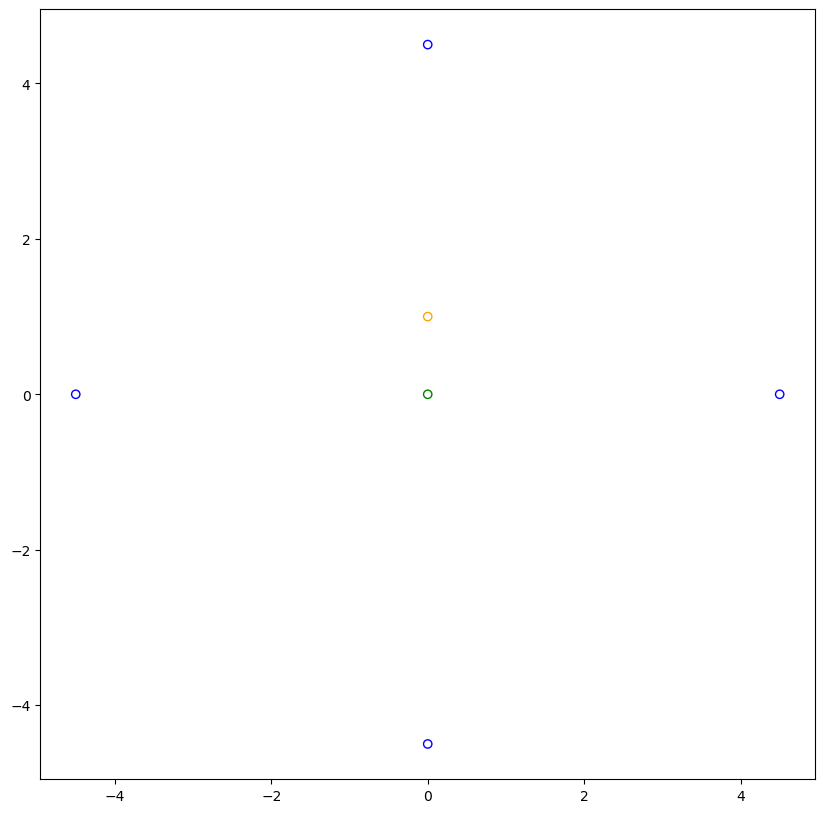

In [22]:
# work with the data (i.e. visualize the path)
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(x=objects_x, y=objects_y, facecolors='none', edgecolors='blue') # objects except ground plane 
plt.scatter(x=robots_x, y=robots_y, facecolors='none', edgecolors='orange') # robots 
plt.scatter(r_x, r_y, facecolors='none', edgecolors='green') # robots 
plt.scatter(lidar_x, lidar_y, s=0.4, color='red') # lidar 